In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, pickle
import sys
from skimage import io
import os

sys.path.append("../../bioseg")

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
data_dir = '/data/natalia/intern20/PaperData/MIBI_1channel/'
pd_file = pd.read_csv(data_dir+'files.csv',index_col=0)
print(pd_file)

   prefix                                        input_dir  input_file  group
0  image0  /data/natalia/intern20/PaperData/MIBI_1channel/  image0.npz  train
1  image1  /data/natalia/intern20/PaperData/MIBI_1channel/  image1.npz   test
2  image2  /data/natalia/intern20/PaperData/MIBI_1channel/  image2.npz   test
3  image3  /data/natalia/intern20/PaperData/MIBI_1channel/  image3.npz  train
4  image4  /data/natalia/intern20/PaperData/MIBI_1channel/  image4.npz   test
5  image5  /data/natalia/intern20/PaperData/MIBI_1channel/  image5.npz  train
6  image6  /data/natalia/intern20/PaperData/MIBI_1channel/  image6.npz   test
7  image7  /data/natalia/intern20/PaperData/MIBI_1channel/  image7.npz  train


## Scribbles generation

In [3]:
## number of label's scribbles
nlabels_budget = 200

/data/natalia/intern20/PaperData/MIBI_1channel/image0.npz


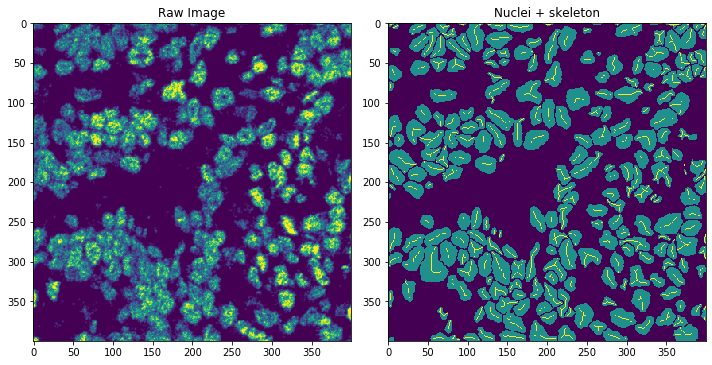

/data/natalia/intern20/PaperData/MIBI_1channel/image3.npz


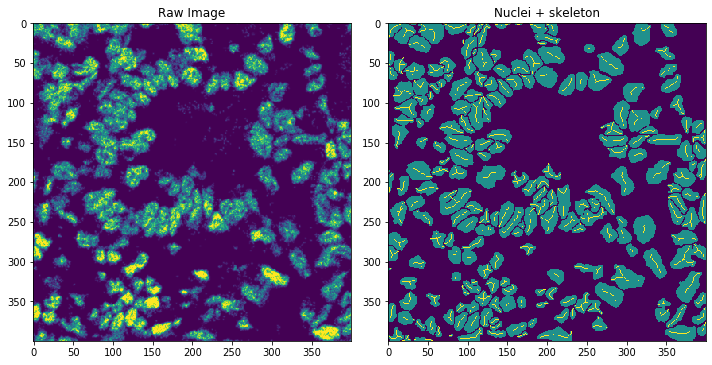

/data/natalia/intern20/PaperData/MIBI_1channel/image5.npz


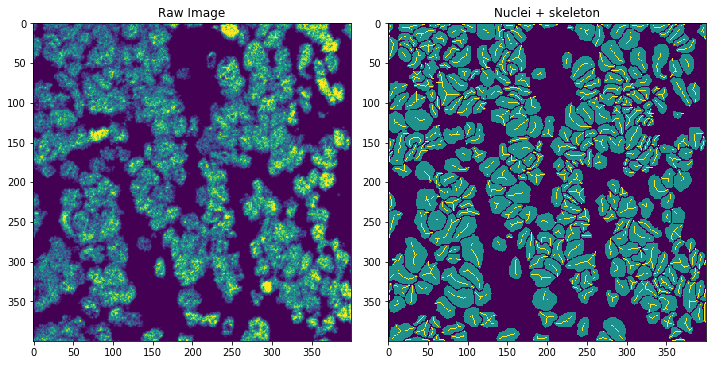

/data/natalia/intern20/PaperData/MIBI_1channel/image7.npz


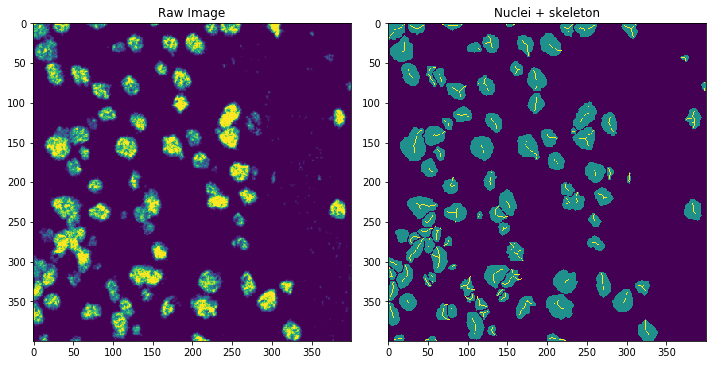

In [4]:
from skimage import morphology
from BioSeg_labelgenerator import get_scribbles

#load train segmentations in a list, and visualize label skeletons
X_train_list = []
Y_gt_train_list = []
files_train_list_aux = []
nlabels_total = 0
for i in range(len(pd_file)):
    group = pd_file['group'][i]
    if group == 'train':

        print(pd_file['input_dir'][i] + pd_file['input_file'][i])
        npz_read = np.load(pd_file['input_dir'][i] + pd_file['input_file'][i])
        image = npz_read['image'] #these images are normalized: normalize(image,pmin=1,pmax=99.8,clip = False)
        label = npz_read['label']
        nlabels_total += np.unique(label).shape[0]-1
        
        X_train_list.append(image)
        Y_gt_train_list.append(label)
        files_train_list_aux.append([pd_file['input_dir'][i],
                                 pd_file['input_file'][i],
                                 pd_file['prefix'][i],])

        #nuclei mask
        nuclei = np.zeros_like(label)
        nuclei[label>0] = 1

        plt.figure(figsize=(10,5))
        skeleton = morphology.skeletonize(nuclei)
        plt.subplot(1,2,1)
        plt.title('Raw Image')
        plt.imshow(image)
          
        plt.subplot(1,2,2)
        plt.title('Nuclei + skeleton')
        plt.imshow(nuclei+skeleton)
        plt.tight_layout()
        plt.show()

In [5]:
## Generate scribbles
Y_out_list_c, nscribbles_list_c, nlabels_list_c = get_scribbles(Y_gt_train_list,
                                                         nlabels_budget,
                                                         fov_box=(32,32),
                                                         radius_pointer=0,
                                                         disk_scribble = False,
                                                         sample_back = False)

sample,nbudget,nscribbles
0 200 50
1 147 49
2 97 48
3 46 46


['/data/natalia/intern20/PaperData/MIBI_1channel/', 'image0.npz', 'image0']


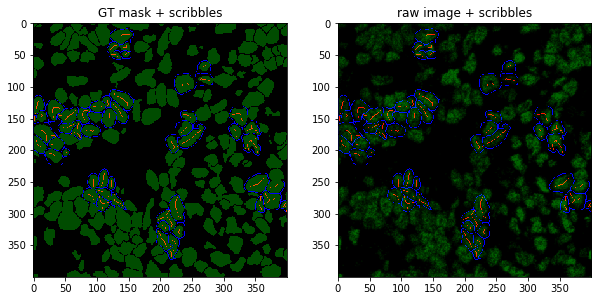

image0_scribble_n200.npz
['/data/natalia/intern20/PaperData/MIBI_1channel/', 'image3.npz', 'image3']


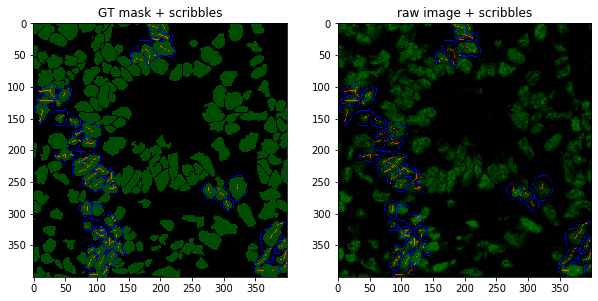

image3_scribble_n200.npz
['/data/natalia/intern20/PaperData/MIBI_1channel/', 'image5.npz', 'image5']


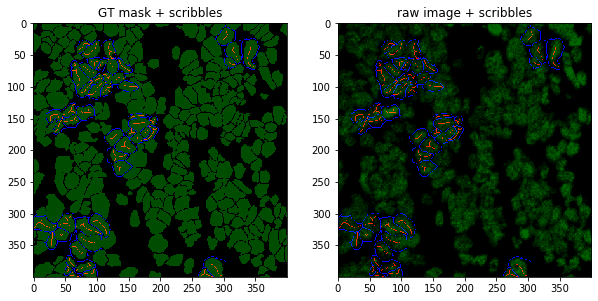

image5_scribble_n200.npz
['/data/natalia/intern20/PaperData/MIBI_1channel/', 'image7.npz', 'image7']


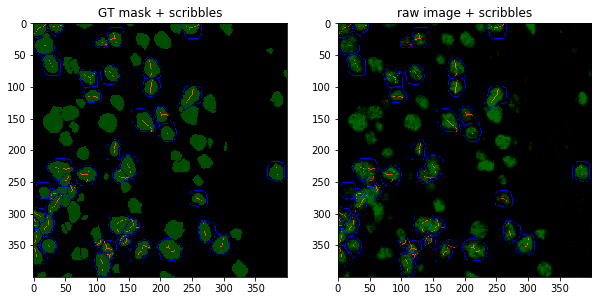

image7_scribble_n200.npz


In [6]:
## Save scribbles

import copy
from csbdeep.utils import normalize

files_train_list = copy.deepcopy(files_train_list_aux)
Y_out = copy.deepcopy(Y_out_list_c)
nscribbles_list = copy.deepcopy(nscribbles_list_c)
nlabels_list = copy.deepcopy(nlabels_list_c)

## Save scribbles
for i in range(len(Y_out)):
    image = X_train_list[i]
    image_plot = normalize(image,pmin=1,pmax=99.8,clip = True)
    label = Y_gt_train_list[i]
    
    print(files_train_list[i])
    
    nuclei = np.zeros_like(label)
    nuclei[label>0] = 1
    
    aux = np.zeros([image_plot.shape[0],image_plot.shape[1],3])
    aux[...,1] = nuclei*0.3
    aux[...,0] = Y_out[i][...,0]
    aux[...,2] = np.sum(Y_out[i][...,1:],axis = 2)
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.title('GT mask + scribbles')
    plt.imshow(aux)


    aux = np.zeros([image_plot.shape[0],image_plot.shape[1],3])
    aux[...,1] = image_plot[...]*0.4
    aux[...,0] = Y_out[i][...,0]
    aux[...,2] = np.sum(Y_out[i][...,1:],axis = 2)

    plt.subplot(1,2,2)
    plt.title('raw image + scribbles')
    plt.imshow(aux)
    plt.show()
    
    name_save = files_train_list[i][1].split('.')[0] + '_scribble_n'+str(int(nlabels_budget))+'.npz'
    print(name_save)
    np.savez(files_train_list[i][0]+name_save,scribble=Y_out[i])
    
    files_train_list[i].extend([name_save,int(len(np.unique(label))),int(nscribbles_list[i])])
#     print(int(rho_list[i]),nlabels_list[i])


In [7]:
pd_scribbles = pd.DataFrame(data=files_train_list,columns=['input_dir','input_file','prefix',
                                                           'scribble_file','total_labels','scribble_labels'])
print(pd_scribbles)

print('Saving in: ')
print(data_dir+'files_scribbles_train_'+str(int(nlabels_budget))+'.csv')
pd_scribbles.to_csv(data_dir+'files_scribbles_train_'+str(int(nlabels_budget))+'.csv',index=None)


                                         input_dir  input_file  prefix  \
0  /data/natalia/intern20/PaperData/MIBI_1channel/  image0.npz  image0   
1  /data/natalia/intern20/PaperData/MIBI_1channel/  image3.npz  image3   
2  /data/natalia/intern20/PaperData/MIBI_1channel/  image5.npz  image5   
3  /data/natalia/intern20/PaperData/MIBI_1channel/  image7.npz  image7   

              scribble_file  total_labels  scribble_labels  
0  image0_scribble_n200.npz           246               53  
1  image3_scribble_n200.npz           226               50  
2  image5_scribble_n200.npz           324               51  
3  image7_scribble_n200.npz            97               46  
Saving in: 
/data/natalia/intern20/PaperData/MIBI_1channel/files_scribbles_train_200.csv


## Dataset patches generation

In [8]:
pd_scribbles = pd.read_csv(data_dir+'files_scribbles_train_'+str(int(nlabels_budget))+'.csv')
pd_scribbles

,input_dir,input_file,prefix,scribble_file,total_labels,scribble_labels
0,/data/natalia/intern20/PaperData/MIBI_1channel/,image0.npz,image0,image0_scribble_n200.npz,246,53
1,/data/natalia/intern20/PaperData/MIBI_1channel/,image3.npz,image3,image3_scribble_n200.npz,226,50
2,/data/natalia/intern20/PaperData/MIBI_1channel/,image5.npz,image5,image5_scribble_n200.npz,324,51
3,/data/natalia/intern20/PaperData/MIBI_1channel/,image7.npz,image7,image7_scribble_n200.npz,97,46


100%|██████████| 1/1 [00:00<00:00, 129.22it/s]


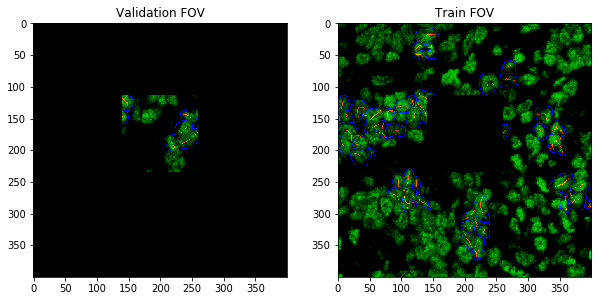

100%|██████████| 1/1 [00:00<00:00, 132.25it/s]


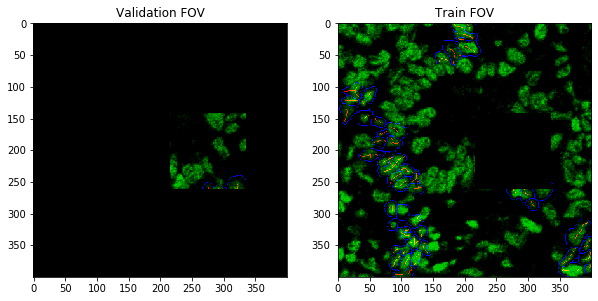

100%|██████████| 1/1 [00:00<00:00, 137.04it/s]


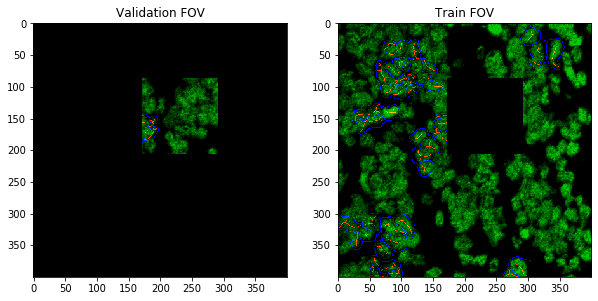

100%|██████████| 1/1 [00:00<00:00, 134.03it/s]


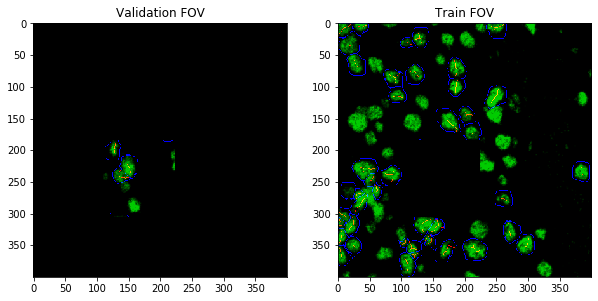

100%|██████████| 1/1 [00:00<00:00, 97.79it/s]


In [9]:

from BioSeg_labelgenerator import get_dataset

n_patches_per_image_train=30
n_patches_per_image_val=8
patch_size=(128, 128)
p_label = 0.6
val_perc = 0.3
verbose = True

X_train,Y_train,X_val,Y_val = get_dataset(pd_scribbles,n_patches_per_image_train=n_patches_per_image_train,
                                          n_patches_per_image_val=n_patches_per_image_val,patch_size=patch_size,
                                          p_label = p_label,val_perc = val_perc,verbose = verbose)

Train size (X,Y)
(120, 128, 128, 1) (120, 128, 128, 2)
Val size (X,Y)
(32, 128, 128, 1) (32, 128, 128, 2)
Patches with at least one label:
Train:,  118
Val:,  31
Sanity check - one hot
[0. 1.]
[0. 1.]

-----------------------  Random Patches -----------------------
train


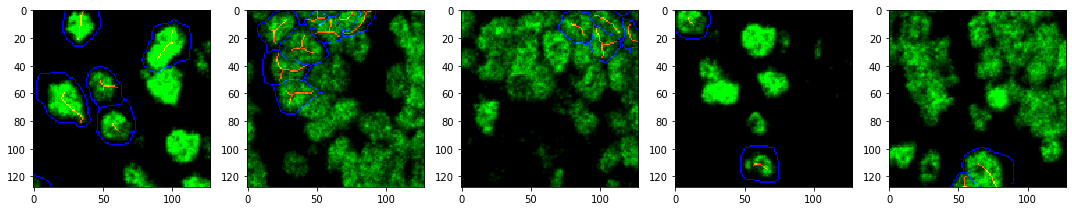

val


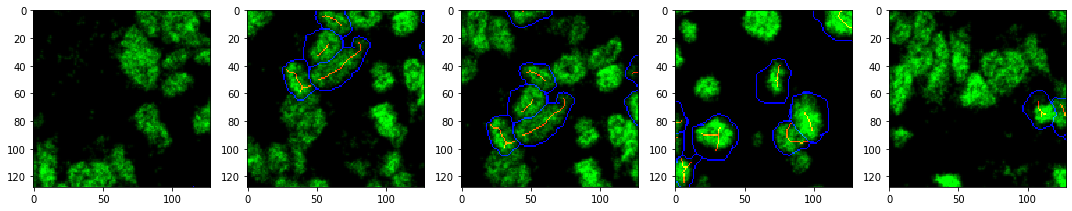

In [10]:
print('Train size (X,Y)')
print(X_train.shape,Y_train.shape)
print('Val size (X,Y)')
print(X_val.shape,Y_val.shape)
print('Patches with at least one label:')
print('Train:, ', np.sum(np.sum(Y_train,axis = (1,2,3))>0))
print('Val:, ', np.sum(np.sum(Y_val,axis = (1,2,3))>0))

print('Sanity check - one hot')
print(np.unique(np.sum(Y_train[...,0:2],axis=-1).flatten()))
print(np.unique(np.sum(Y_val[...,0:2],axis=-1).flatten()))

print()


################# PLOT RANDOM PATCHES #################

print('-----------------------  Random Patches -----------------------')
ix_1 = 0
print('train')
index = np.arange(Y_train.shape[0])
np.random.shuffle(index)
cont = 1
plt.figure(figsize = (15,4))
for ix in index[0:5]:
    img_plot = np.concatenate([Y_train[ix,:,:,ix_1][...,np.newaxis],
                               X_train[ix,:,:,0][...,np.newaxis],
                               Y_train[ix,:,:,ix_1+1][...,np.newaxis]],axis = -1)
    
    plt.subplot(1,5,cont)
    cont += 1
    plt.imshow(img_plot)
#     plt.colorbar()
#     print(np.unique(img_plot[...,0].flatten()),np.unique(img_plot[...,2].flatten()))
plt.tight_layout()
plt.show()

print('val')
index = np.arange(Y_val.shape[0])
np.random.shuffle(index)
cont = 1
plt.figure(figsize = (15,4))
for ix in index[0:5]:
    img_plot = np.concatenate([Y_val[ix,:,:,ix_1][...,np.newaxis],
                               X_val[ix,:,:,0][...,np.newaxis],
                               Y_val[ix,:,:,ix_1+1][...,np.newaxis]],axis = -1)
    
    plt.subplot(1,5,cont)
    cont += 1
    plt.imshow(img_plot)
#     print(np.unique(img_plot[...,0].flatten()),np.unique(img_plot[...,2].flatten()))
plt.tight_layout()
plt.show()


### Save dataset

In [11]:
data_save_file = data_dir+'dataset_bioseg_noaug_n'+str(int(nlabels_budget))+'.npz'
print(data_save_file)

/data/natalia/intern20/PaperData/MIBI_1channel/dataset_bioseg_noaug_n200.npz


In [12]:
np.savez(data_save_file, X_train=X_train, Y_train=Y_train.astype('int'),
         X_val=X_val, Y_val=Y_val.astype('int'))
print('saving dataset :: ', data_save_file)

saving dataset ::  /data/natalia/intern20/PaperData/MIBI_1channel/dataset_bioseg_noaug_n200.npz
